Body size and range size relationship of avian scavengers
=================

[1. Proposal](#1-proposal)

[2. Preamble](#2-preamble)

[3. Data exploration](#3-data-exploration)

[4. Analyses](#4-analyses)

[4.1 Global avian scavengers without dietary distinction](#4.1-global-avian-scavengers-without-dietary-distinction)

[4.2 Obligate and facultative scavengers](#4.2-obligate-and-facultative-scavengers)

[5. References](#5-references)

# 1. Proposal

* Explain the triangle-shaped distribution
* More clearly state hypotheses and rationale

## Background

* Original hypothesis was that we would see a positive relationship, but this was before we expanded to global birds. But note that there's an effective size limit on how big birds can get
1. We expect to see a slightly negative relationship when looking at scavengers as a whole due to the number of obligate scavengers dominating the large body size classes that have small EOOs; the extremeness of the large size paired with the small EOO of those obligates may be enough to affect the linear relationship across all species, contrary to the expected relationship between bigger body sizes and larger EOOs [cite: Brown and Maurer 1989]. 
2. We anticipate that separating the obligate and facultative scavengers into their own groups will reveal different BSRS relationships. The range size of obligate scavengers will be limited by body size, because they are so large they must remain in geographic areas that facilitate flight, such as the Andean condor living in exclusively mountainous regions with strong updrafts [CITATION]. Therefore, we expect to see a negative relationship between BS and RS. However, facultative scavengers may show a positive body size-range size relationship that more closely matches the expectations outlined by Brown and Maurer 1989, because we are considering so many more species with a greater variability in body sizes; refer to that paper that showed mammals with bigger body sizes are kinda ecologically required to have larger ranges.

<!-- The range size of obligate scavengers will be limited by body size, because we have so many large sp within this group and will drag the line down -->

## Objectives

### Significance

* Highlights the importance of scale in macroecological research. What we already recognize in macroecology of that "rule" in macroecology of larger body sizes means larger range sizes and that diff patterns can be viewed at different scales, and the further we break down relationships between taxa the more the "rule" of BSRS disintegrates.
* Looks at that rule of BSRS [cite Brown and Maurer 1989] and looks at how that rule breaks down as we change the taxonomic scale under consideration.

### Methods

We will study 65 species of 22 obligate and 43 facultative avian scavengers from around the world. eBird is a bird-watching database with a wealth of observation records that we will use to calculate the extent of occurrence (EOO) of each species.

We draw from the methods used by [Blackburn and Gaston (1986)](https://www.jstor.org/stable/56368) to evaluate the relationship between the body size and the range size of obligate and facultative avian scavenger species. First we examine them as a single entity and then compare the effect diet strategy may have on the body size-range size relationship.

# 2. Preamble

Import libraries and set global options.

In [1]:
import pandas as pd  # For manipulating data structures
import numpy as np  # For mathematical functions
import scipy.stats as stats  # Algorithms and convenience functions built on NumPy
import statsmodels.api as sm  # For statistical methods
import matplotlib.pyplot as plt  # Essentially the Python equivalent to ggplot2
import seaborn as sns  # A library for statistical graphics built on Matplotlib

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    rc=custom_params,
)

Read the data, excluding the columns Cara and I used for bookkeeping. I will index by species names rather than by row numbers to make working with the DataFrame more intuitive.

In [2]:
columns = [
    "Species name",
    "Scientific name",
    "Diet",
    "Extent of occurrence",
    "BirdLife Extent of occurrence",
    "Body size",
]

scavengers = pd.read_csv(
    "../data/MacroEco scavenger data.csv", usecols=columns, index_col="Species name"
)

Find and display any rows that have `NaN` (Not a Number) values.

In [3]:
scavengers.loc[scavengers.isnull().any(axis=1)]

,Scientific name,Diet,Extent of occurrence,BirdLife Extent of occurrence,Body size
Species name,,,,,
Hooded crow,Corvus cornix,Facultative,21136393.72,NaN,650


BirdLife currently lists no data for the extent of occurrence (EOO) for the hooded crow, so let's drop it from our dataset.

In [4]:
scavengers.drop(["Hooded crow"], inplace=True)

Let's add new columns that have the log-transformed values for EOO and body size. We will use the base 10 system, because we are dealing with spatial ranges and it is easier to interpret distances in $log_{10}$ than the natural log, which uses base $e$.

In [5]:
scavengers["log Extent of occurrence"] = np.log10(scavengers["Extent of occurrence"])
scavengers["log Body size"] = np.log10(scavengers["Body size"])

scavengers.head()

,Scientific name,Diet,Extent of occurrence,BirdLife Extent of occurrence,Body size,log Extent of occurrence,log Body size
Species name,,,,,,,
Black vulture,Coragyps atratus,Obligate,42593865.0,44300000.0,2200,7.629347,3.342423
Turkey vulture,Cathartes aura,Obligate,52285085.0,47100000.0,2500,7.718378,3.397940
Lesser yellow headed vulture,Cathartes burrovianus,Obligate,19989926.0,19600000.0,950,7.300811,2.977724
Greater yellow headed vulture,Cathartes melambrotus,Obligate,7481821.0,7330000.0,1650,6.874007,3.217484
King vulture,Sarcoramphus papa,Obligate,17390218.0,22600000.0,3800,7.240305,3.579784


Let's also make separate DataFrames for obligate and scavenger species.

In [6]:
obligates = scavengers.loc[scavengers["Diet"] == "Obligate"]
facultatives = scavengers.loc[scavengers["Diet"] == "Facultative"]

# 3. Data exploration

Compare the raw data of the EOO from BirdLife and the EOO that Cara and I calculated in ArcGIS with the convex hull method.

In [7]:
# fig, (ax1, ax2) = plt.subplots(
#     1,  # The number of rows in my plot.
#     2,  # The number of columns in my plot.
#     figsize=(12, 5),
#     sharex=True,
# )

# sns.scatterplot(
#     ax=ax1,
#     x="Body size",
#     y="BirdLife Extent of occurrence",
#     hue="Diet",
#     data=scavengers,
# )
# sns.scatterplot(
#     ax=ax2,
#     x="Body size",
#     y="Extent of occurrence",
#     hue="Diet",
#     data=scavengers,
# )
# ax1.set_xlabel("Body size (g)")
# ax2.set_xlabel("Body size (g)")
# ax1.set_ylabel("BirdLife Extent of occurrence (km$^2$)")
# ax2.set_ylabel("Extent of occurrence (km$^2$)")
# plt.xscale("log")  # Default log scale used by Seaborn is base 10, not natural log.
# plt.show()

They don't look too terribly different so that's a good sign for how we calculated the EOO in ArcGIS, considering how BirdLife has access to more sources of data.

With that newly instilled confidence, let's look at how the data is distributed.

## 3.1 Distribution



### 3.1.1 Histograms

I used Copilot for assistance refactoring the code when my for loops kept failing to combine the raw and log-transformed data.

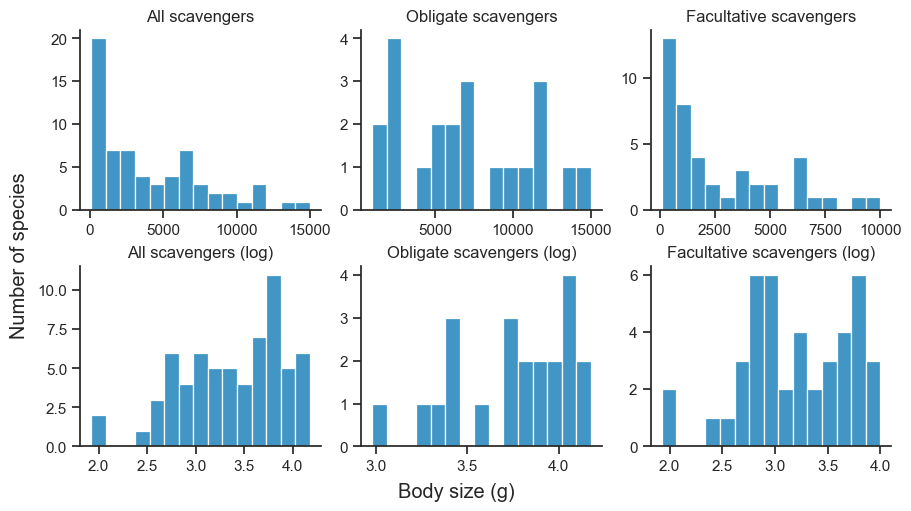

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(9, 5), layout="constrained")

data = [scavengers, obligates, facultatives]
titles = ["All scavengers", "Obligate scavengers", "Facultative scavengers"]

# Plot first row of histograms of raw data
for ax, d, title in zip(axes[0], data, titles):
    sns.histplot(ax=ax, data=d, x=d["Body size"], bins=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title)

# Plot the second row with log-transformed data
for ax, d, title in zip(axes[1], data, titles):
    sns.histplot(ax=ax, data=d, x=d["log Body size"], bins=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title + " (log)")

# Set figure-level labels
fig.supxlabel("Body size (g)")
fig.supylabel("Number of species")

plt.show()

The above log-transformed histograms for "All scavengers" and "Facultative scavengers" look similar to Figure 1, C and D in Brown and Maurer (1989) when they reduced their spatial scale. Our histograms indicate that a similar effect may be achieved by narrowing the taxonomic focus while maintaining a large geographic scale. "Obligate scavengers" looks more similar to when the spatial scale is highly restricted (Brown and Maurer, 1989; Fig 1, E, F).

A histogram of the log-transformed EOO is below and shows a left-skewed distribution:

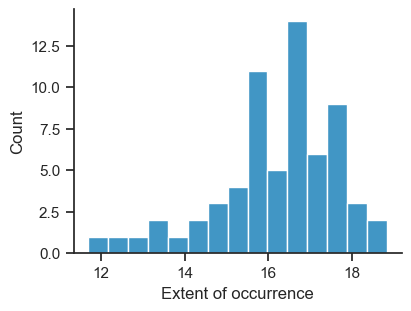

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), layout="constrained")
sns.histplot(
    data=scavengers,
    x=np.log(scavengers["Extent of occurrence"]),
    bins=15,
)
plt.show()

### 3.1.2 Statistical tests of normality and skewness

In [10]:
# jb_test = stats.jarque_bera(x=scavengers["Body size"])
body_jb_test = stats.jarque_bera(x=np.log(scavengers["Body size"]))

eoo_jb_test = stats.jarque_bera(x=np.log(scavengers["Extent of occurrence"]))

# print(f"Raw Data Jarque-Bera Test:\nStatistic: {jb_test.statistic:.2f}, p-value: {jb_test.pvalue:.5f}")
print(f"Body size Data Jarque-Bera Test:\nStatistic: {body_jb_test.statistic:.2f}, p-value: {body_jb_test.pvalue:.5f}")

print(f"EOO Jarque-Bera Test:\nStatistic: {eoo_jb_test.statistic:.2f}, p-value: {eoo_jb_test.pvalue:.5f}")

Body size Data Jarque-Bera Test:
Statistic: 4.07, p-value: 0.13076
EOO Jarque-Bera Test:
Statistic: 9.46, p-value: 0.00884


The Raw Data Jarque-Bera test statistic concurs with the above histograms that our data distribution is not normally distributed when examining all scavengers as a single group, but that the body size data are normally distributed when log-transformed.

In [11]:
skewness_raw = scavengers["Body size"].skew()
skewness_log = np.log(scavengers["Body size"]).skew()

print(f"Skewness of Raw Data: {skewness_raw:.2f}")
print(f"Skewness of Log-Transformed Data: {skewness_log:.2f}")

Skewness of Raw Data: 1.00
Skewness of Log-Transformed Data: -0.62


-------------
# 4. Analyses

We log transform both variables to make the data approximately linear to meet the assumptions of a classical linear regression model that uses OLS. Since we are able to meet the assumptions, we don't need the added flexibility that a generalized linear model provides.

## 4.1 Global avian scavengers without dietary distinction

**Define the variables**

Linear models are at their core just a bunch of matrices in a trench coat, though we don't often think of them like this.
Written out as matrices, the linear equation $y=X\beta+\epsilon$ looks like

$$
\begin{equation}
    \begin{bmatrix}
        y_1 \cr
        y_2 \cr
        \vdots \cr
        y_n
    \end{bmatrix}
    =
    \begin{bmatrix}
        1 & x_1 \cr
        1 & x_2 \cr
        \vdots & \vdots \cr
        1 & x_n
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
        \beta_0 \cr
        \beta_1
    \end{bmatrix}
    +
    \begin{bmatrix}
        \epsilon_1 \cr
        \epsilon_2 \cr
        \vdots \cr
        \epsilon_n
    \end{bmatrix}
\end{equation}
$$

The design matrix, $X$, is handled differently between different libraries, whether working in R or Python. In our case, the Statsmodels library does not include a constant term by default in the `OLS` function, so we must do this ourselves.
The way to do this is with the `add_constant` function to add a constant term to the linear equation. ([Statsmodels tools.add_constant](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html), [.pyTutorial, 2025.](https://pytutorial.com/python-statsmodels-add_constant-explained/)).

The design matrix will come up again in section [4.2 Obligate and facultative scavengers](#4.2-Obligate-and-facultative-scavengers).

<!-- The intercept term is the expected value of the dependent variable when the fixed variables are zero. -->
<!-- The way to do this is with the `add_constant` function to add a constant term, which is the intercept of the regression line. What `add_constant` does is it adds a column of ones to the dataset. -->

In [12]:
# Define the X and Y matrices
y = np.log(scavengers["Extent of occurrence"])
x = np.log(scavengers["Body size"])  # N.B. Numpy uses the natural log by default.
x = sm.add_constant(x)  # Add a column called "const" to the design matrix.
x.head()

,const,Body size
Species name,,
Black vulture,1.0,7.696213
Turkey vulture,1.0,7.824046
Lesser yellow headed vulture,1.0,6.856462
Greater yellow headed vulture,1.0,7.408531
King vulture,1.0,8.242756


**Fit the OLS model using our EOO data.** 
<!-- A second model is available to view BirdLife EOO data's model fit. -->

`fit` uses the Moore-Penrose pseudoinverse method ([Statsmodels OLS.fit](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html)), a commonly used method to solve the least squares system of linear equations ([Wolfram Mathworld, Moore-Penrose Matrix Inverse](https://mathworld.wolfram.com/Moore-PenroseMatrixInverse.html)).

In [13]:
ols_model = sm.OLS(y, x).fit()

print(ols_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Extent of occurrence   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.015
Method:                   Least Squares   F-statistic:                   0.03002
Date:                  Fri, 11 Apr 2025   Prob (F-statistic):              0.863
Time:                          15:09:01   Log-Likelihood:                -116.46
No. Observations:                    65   AIC:                             236.9
Df Residuals:                        63   BIC:                             241.3
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0155      1.185

The `coef` column shows the OLS regression coefficients, from which we can determine our regression equation:

$y_i = \beta_0 + \beta_1x_i$

EOO $_i$ = 16.02 + 0.0261 $\cdot$(Body size $_i$)

This is practically a flat line, shown below, indicating that there's basically no effect of body size on EOO across avian scavenger species and is corroborated by the $R^2$ value of <0.05. The p-value, 0.863, also suggests no relationship between body size and range size in avian scavengers.

The Jarque-Bera test shows that the residuals are definitely not normally distributed (9.479, p < 0.00874).

In [ ]:
sns.residplot(data=ols_model.resid, x="Body size", y="Extent of occurrence")

<Axes: >

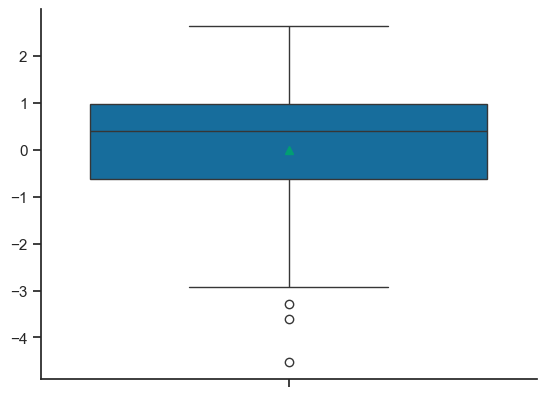

In [18]:
sns.boxplot(ols_model.resid, showmeans=True)

Make a Q-Q plot and include a standardized line.

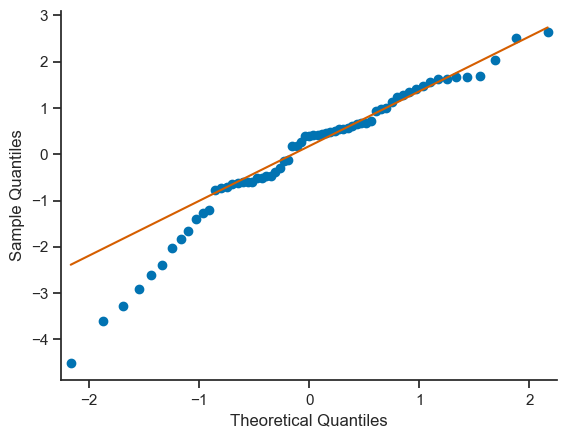

In [33]:
sm.qqplot(ols_model.resid, line="q")
plt.show()  # Needed to prevent Statsmodels from printing two identical plots.

Text(0, 0.5, 'EOO (km$^2$)')

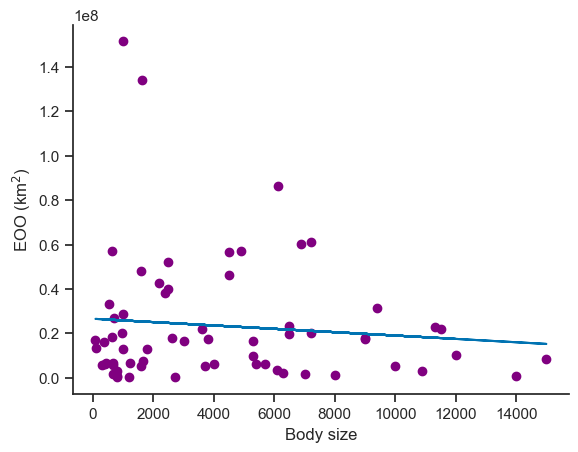

In [ ]:
# Fit a polynomial with least squares polynomial fit
a, b = np.polyfit(
    x=scavengers["Body size"], y=scavengers["Extent of occurrence"], deg=1
)

plt.scatter(
    y=scavengers["Extent of occurrence"], x=scavengers["Body size"], color="purple"
)
plt.plot(scavengers["Body size"], a * scavengers["Body size"] + b)

plt.xlabel("Body size (g)")
plt.ylabel("EOO (km$^2$)")

# plt.text(1, 90, "y = " + "{:.3f}".format(b) + " + {:.3f}".format(a) + "x", size=12)
# plt.xscale("log")

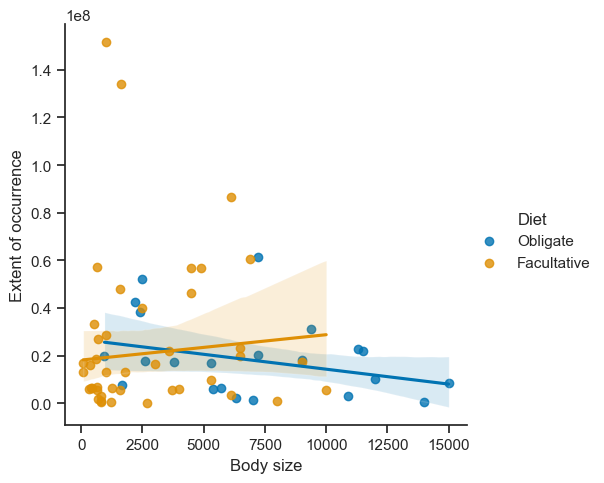

In [51]:
sns.lmplot(
    x="Body size",
    y="Extent of occurrence",
    hue="Diet",
    data=scavengers,
    scatter=True,
    legend=True,
    # logx=True,
    robust=True
)

## 4.2 Obligate and facultative scavengers

Now we want to include an interaction term in our regression to test the  We have two predictor variables, $x_1$ and $x_2$, for body size and diet. The first is quantitative continuous data, and the latter is categorical 

In [ ]:
import patsy 

logEOO = np.log10(scavengers["Extent of occurrence"])
logBodySize = np.log10(scavengers["Body size"])

# Make the design matrices with Patsy
y, X = patsy.dmatrices('logEOO ~ logBodySize * Diet', data=scavengers, return_type='dataframe')

dummy_interaction_OLS = sm.OLS(y, X).fit()
print(dummy_interaction_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 logEOO   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7522
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.525
Time:                        13:45:27   Log-Likelihood:                -61.086
No. Observations:                  65   AIC:                             130.2
Df Residuals:                      61   BIC:                             138.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [62]:
# Extract coefficients from the model
intercept = dummy_interaction_OLS.params["Intercept"]
diet_obligate_coef = dummy_interaction_OLS.params["Diet[T.Obligate]"]
log_body_coef = dummy_interaction_OLS.params["logBodySize"]
interaction_coef = dummy_interaction_OLS.params["logBodySize:Diet[T.Obligate]"]

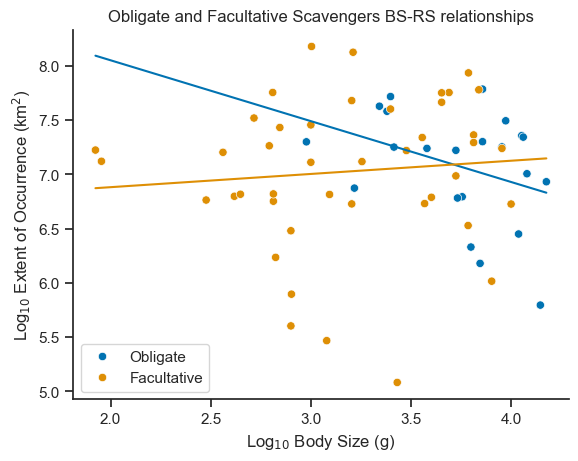

In [ ]:
log_body_values = np.linspace(
    np.log10(scavengers["Body size"]).min(),
    np.log10(scavengers["Body size"]).max(),
    100,
)

# Calculate regression lines for obligate and facultative scavengers
log_eoo_obligate = (
    intercept
    + log_body_coef * log_body_values
    + diet_obligate_coef
    + interaction_coef * log_body_values
)
log_eoo_facultative = intercept + log_body_coef * log_body_values

# Create a scatter plot with regression lines for obligate and facultative scavengers
sns.scatterplot(
    data=scavengers,
    x=np.log10(scavengers["Body size"]),
    y=np.log10(scavengers["Extent of occurrence"]),
    hue="Diet",
)

# Plot regression lines
plt.plot(log_body_values, log_eoo_obligate)
plt.plot(log_body_values, log_eoo_facultative)

plt.xlabel("Log$_{10}$ Body Size (g)")
plt.ylabel("Log$_{10}$ Extent of Occurrence (km$^2$)")
plt.legend()
plt.title("Obligate and Facultative Scavengers BS-RS relationships")

plt.show()

------------
# 5. References

BirdLife International (2025). IUCN Red List for birds. Last visited 2025-03-14. https://datazone.birdlife.org/

James H. Brown, Brian A. Maurer (1989). Macroecology: The Division of Food and Space Among Species on Continents. Science *243*, 1145-1150. [DOI:10.1126/science.243.4895.1145](https://doi.org/10.1126/science.243.4895.1145).